# Errors 
> The errors of a wise man makes your rule \
> Rather than the perfections of a fool \
-William Blake

A summary by Marcus Mähring: mmaehring@student.ethz.ch

Doing experiments involve making measurements, which are then analysed to produce results. These measurements will <i>never</i> be perfectly exact, but have some <i>resolution</i> or <i>error</i>. 

Here we wish to understand how measurements combine and propagate through to errors manifesting on the results. When values are quoted with an error, <i>this is a Gaussian standard deviation</i> $\sigma$.<br>
__Example:__ If we say a piece of string has the length $12.3\pm0.1$cm we mean that you have measured it with some device which gives answes that differ from the true value by within 0.1 cm 68% and within 0.3cm 99.7% of the time, which is motivated with a Gaussian 

__Very important remark:__ In engineering the same notation denotes <i>tolerance</i>, i.e, $12.3 \pm 0.1$ is a guarantee that the vallue lies between $12.2$cm and $12.4$cm. 

In [1]:
using StatsPlots, Distributions, Measurements, Random, Unitful, Zygote, LinearAlgebra

## Why errors are Gaussian
Measurements acquire errors from many different sources. For instance, when measuring a rod using a ruler a non-exhaustive list of possible inexactitudes is:
- Optical parallax (from which angle are you viewing the ruler? How is the lighting, i.e., can you read of the values accurately?)
- Calibration of the ruler (are the numbers in the right place?)
- Rounding errors (The ruler has a finite accuracy)
- Hand shaking, vibrations from the neighbour vacuuming etc...

Similar problems exist for most experiments, however, I concede that the erors may be slightly more subtle or advanced in nature than above. Instead of manifesting as something as palpable as tiredness, shaking or a faulty ruler, the problem will lay in the depths of electronics. 

There is a powerful and suprising result about the behaviour of a variable which is the sum of several others. It is called the __central limit theorem__ or __<i>CLT</i>__. 

##### Theorem: CLT 
If you take the sum $X$ of $N$ independent variables $x_i$, where $i=1,2,3,...N$, each taken from a distribution of mean $\mu_i$, and variance $V_i$ or $\sigma_i^2$, the distribution for $X$

a) has an expectation value     
$$\langle X \rangle = \sum \mu_i$$

b) has variance
$$V(X) = \sum V_i = \sum \sigma_i^2$$

c) becomes Gaussian as   $N \rightarrow \infty$


This is the reason why the Gaussian distribution is so important: <i>a quantity produced via a cumulative effect of many independant variables will at least approximately be Gaussian</i>. Note that this statement is independent of distribution!

__Remark:__ The CLT works better near the center of the distribution, becoming less reliable far away from the centre. Distributions can be indistinguishable from a Gaussian within one or two $\sigma$, but deviate farther away (in the tails of the distribution). 

### More on the CLT
The proof of the two first statements of the above theorem can easily be done using basic properties of expectation values: <br>
For a), recall: $X = \sum_i x_i$, then calculating the expectation value gives:
$$
     \langle X \rangle = \left\langle\sum_i x_i\right\rangle = \sum_i \langle x_i \rangle = \sum_i \mu_i
$$
For b), the proof is slightly more complicated: 
$$
    V(X) = \langle (X - \langle X \rangle)^2 \rangle = \left\langle \left( \sum_i x_i - \sum_i \mu_i \right)^2\right\rangle = \left\langle \left[ \sum_i (x_i -  \mu_i) \right]^2\right\rangle
$$
Now, we split the sum by considering the first term squared and then writing a series expression of all combinations of the necessary $x_i$'s and $x_j$'s. 
$$
    V(X) = \left\langle \sum_i (x_i - \mu_i)^2 \right\rangle + \left\langle \sum_i\sum_{i\neq j} (x_i - \mu_i)(x_j-\mu_j) \right\rangle = \sum_i \langle (x_i - \mu_i)^2 \rangle + \sum_i\sum_{i\neq j}\langle(x_i-\mu_i)(x_j-\mu_j)\rangle
$$

Finally, c) is quite intricate, and I don't feel like summarizing it, so see appendix 2. 


In the following plot, the 

__A__ Shows a histogram of 5000 numbers taken at random from a uniform distribution between 0 and 1, meaning it has mean 1/2 and variance 1/12.  It is essentially flat, and certainly not Gaussian

__B__ Another 5000 numbers, each consisting of a pair of random numbers like those in A: $X = x_1 + x_2$. The distribution is rather triangular. 

__C__ Three uniformly distributen random numbers. The form is curved but not yet Gaussian. 

__D__ Twelve such random numbers, the histogram appears like a true Gaussian. A fit is included for convenience

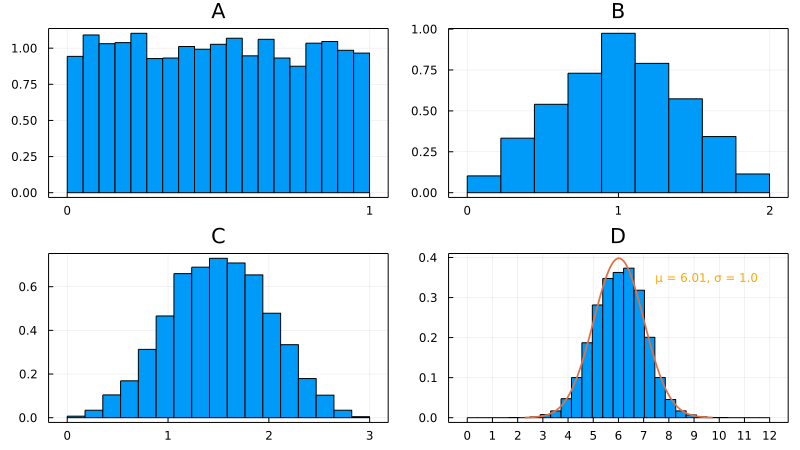

In [2]:
distr = Uniform() # plot(distr, ylim=(0,1.25), xlim=(-0.5, 1.5), label="Mean: 1/2, Variance 1/12")
Random.seed!(3);

A = rand(distr, 5000);
Aplt = histogram(A, bins=range(minimum(A), stop = maximum(A), length = 20), legend=:none, xticks=0:1, title="A", normalize=true)

B = [(rand(distr)+rand(distr)) for i in 1:5000];
Bplt = histogram(B, bins=range(minimum(A), stop = 2*maximum(A), length = 10), legend=:none, xticks=0:1:2, title="B", normalize=true)

C = [(rand(distr)+rand(distr)+rand(distr)) for i in 1:5000];
Cplt = histogram(C, bins=range(minimum(A), stop = 3*maximum(A), length = 18), legend=:none, xticks=0:1:3, title="C", normalize=true)

D = [sum([rand(distr) for j in 1:12]) for i in 1:5000];
Dplt = histogram(D, bins=range(minimum(A), stop = 12*maximum(A), length = 30), legend=:none, xticks=0:1:12, title="D", normalize=true)
gfit = fit(Normal{Float32}, D)
plot!(gfit, lw=1.75)
annotate!(9.5,0.35,text("μ = $(round(location(gfit),digits=2)), σ = $(round(scale(gfit),digits=2))", 8, :orange))

lyt = @layout[a b ; c d]
plot(Aplt, Bplt, Cplt, Dplt, layout=lyt, size=(800, 450), framestyle=:box)

## Working with errors 
Now understanding what we refer to when we mean errors and gone into some depth regarding their nature, let us discuss the fundamentals arising from working with them. 
### Repeated measurements
Suppose the same quantity is measured many times, this is a typical application area of the CLT. In this case it is also way simpler, as the expectation values for the variables $x_i$ ($\mu_i$) all take on the same value, which we will call $\mu$. Likewise, they all have the same value for $\sigma_i$, $\sigma$. Thus we get:
$$
    \langle X \rangle = \sum_i \mu = N \mu \overset{\bar{x} = X/N}{\implies} \langle \bar{x} \rangle = \mu \\
    V(\bar{x}) = \frac{1}{N^2}\sum_i V_i = \frac{\sigma^2}{N}
$$
The former statement is trivial, but the latter requires slightly more explanation. From the CLT with the errors being the same for all measurements, we get
$$
    V(X) = N \sigma^2
$$
Now we replace $X$ with $\bar{x}\cdot N$, as above, we get:
$$
    V(\bar{x}) = \left\langle \left( \frac{x}{N} - \left\langle\frac{x}{N}\right\rangle\right)\right\rangle = \left\langle \frac{x^2}{N^2}\right\rangle - \left\langle \frac{x}{N} \right\rangle^2 = \frac{1}{N^2} \underbrace{\left(\langle x^2 \rangle - \langle x \rangle^2 \right)}_{V(X)} = \frac{N \sigma^2}{N^2} = \frac{\sigma^2}{N}
$$

#### A very important distinction
A certain amount of confusion is bound to occur when discussing these quantities: "why are we taking the average of the average $\langle \bar{x} \rangle$?", and "what is the variance of $\bar{x}$? I thought this was just a way to describe the position of data?"

This will become more clear in chapter 5 about estimators, but Barlow gives an excellent description one can keep in mind, and I thus quote it 1:1.

> 'What is this thing $\langle \bar{x} \rangle$?' you ask. 'What do you mean by the average average x?'. Let us spell it out. You take $N$ measurements $x_1, x_2, \dots, x_n$ and average them:  this average is called $\bar{x}$. This result is still subject to statistical fluctuations, but on average its value will be $\mu$ -- sometimes more, sometimes less, but on average it will be $\mu$, i.e. $\langle \bar{x} \rangle = \mu$. The difference between your actual measured $\bar{x}$ and the 'true' value $\mu$ is described by some distribution which has variance $V(\bar{x}) = \sigma^2 / N$.

An important result of this is that the error of the mean scales like $1/\sqrt{N}$, which is the well known rule "averaging is good for you" and the law of diminishing returns. 

> To get twice as good a resolution you need four times as many measurements. 

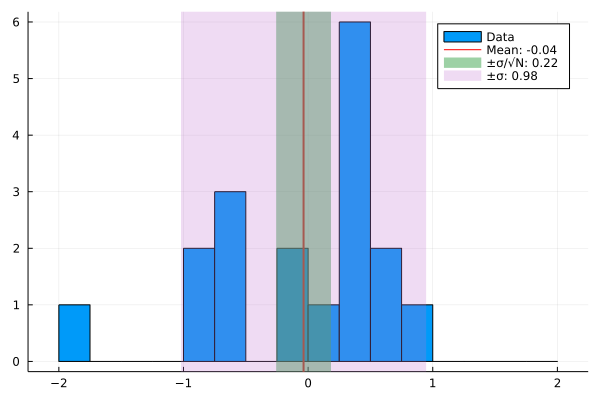

In [3]:
Random.seed!(1);
x = rand(Normal(0, 1), 20)
error_of_mean = std(x)/√length(x)

histogram(x, bins=-2:0.25:2, label="Data")
vline!([mean(x)], label="Mean: $(round(mean(x), digits=2))", lw=2, color=:red)
vspan!([mean(x)-error_of_mean, mean(x)+error_of_mean], α=0.5, label="±σ/√N: $(round(error_of_mean, digits=2))")
vspan!([mean(x)-std(x), mean(x)+std(x)], α=0.25, label="±σ: $(round(std(x), digits=2))")

I we take $N$ independent measurements their average has an exception value which is exactly the desired quantity and as the variance fall like $1/N$, the resolution or "error" on the average is $\sigma/\sqrt{N}$, which is smaller by a factor $1/\sqrt{N}$ than the error on a single measurement (<i>this holds for any distribution, not just the Gaussian</i>).

We call $\sigma/\sqrt{N}$ the __standard error on the mean__, as it describes how well you know the mean of a distribution, which is often a very important quantity. 

<b> Example: Photon energy measurements </b><br>
The energy resolution of a $\gamma$-ray detector used to investigate a decaying nuclear isotope is $50$keV. If only one such decas is observed, its energy is known to $50$keV. If 100 are collected, this improves to $5$keV. 

To reach $1$keV you would need to observe 2500 decays:
$$
    1 \overset{!}{=} \frac{50}{\sqrt{N}} \implies N = 50^2 = 2500
$$

<b> Example: Weights of eggs </b><br>
Weights of eggs produced byt hens at a farm have a standard deviation of $10$g. 
He feeds a group of hens an expensive vitamin supplement, which will pay back its cost if it increases the weight of the eggs by $2$g. He measures $25$ eggs from vitamin-fed hens and their average has increased by $3$g. Does this prove anything useful?

Answer: No. The standard deviation of the mean is $10/\sqrt{25} = 10/5 = 2$ so the increase is only $1.5\sigma$ and is not significant. 

<i>Note:</i> that the variation in the egg weights comes from the spread in the objects themselves, not from the measurement process; it is assumed that the eggs can be weighed with complete accuracy, or at any rate an accuracy much better than $10$g, which is probably true. 

### Averaging weighted measurements
Let us now suppose we have a set of measurements $\{x_i\}$ of some quantity $\mu$ and that these measurements have different errors $\sigma_i$. To combine these values we want to give more weight to variables with better accuracy. 

<b>Example</b>: Suppose a voltage has been measured as such:

<table>
    <tr>
        <th> U </th>
        <td> 3.11 </td>
        <td> 3.13 </td>
    </tr>
    <tr>
        <th> σ </th>
        <td> 0.02 </td>
        <td> 0.01 </td>
    </tr>
</table>

Now suppose we took 4 measurements with the poorer $0.02$ volt resolution meter and averaged then the average would have a precision of $0.02/\sqrt{4} = 0.01$ volts. Four poor measurements are equivalent to one measurement which is twice as good (half the error). Running the argument backwards, assigning the poorer estimate a quarter of the weight of the good estimate we get:
$$
    \bar{V} = \frac{1}{5} \times 3.11 + \frac{4}{5}\times 4.13 = 3.126 V
$$

In general:
$$
    \bar{x} = \frac{\sum x_i / \sigma_i^2}{\sum 1 / \sigma_i^2}
$$

What about the resolution of this average? In this case it is obviously $0.022/\sqrt{5} = 0.009$, which generalizes to a variance of 
$$
    V(\bar{x}) = \frac{1}{\sum 1/\sigma_i^2}
$$


#### A note of caution about averaging results
You should try to get some understanding of the data before trying to average or sort points depending on quality. 

The prompted question is: <i>What is the correct way to deal with data points (outliers) which may well be $\geq 3\sigma$ away from the rest of your data, how do we deal with it?</i> 

1) Check the readings. You may well find a misplaced decimal point, or a couple of transposed numbers. 

2) Maybe redo the measurement? 

3) If there is no obvious mistake, you may well have to throw this point away. HOWEVER, this should be done with a great reluctance. Also, if there are several such measurements, or we find several points with large ($>2\sigma$) deviations, you should be extremely suspicious: there is something going on either in your setup or in the theory which you do not understand. 

Finally, distrust any algorithm that advise automatic rejection of points outside certain limits as they can rapidly loose important information about your setup or experiment. 

A famous example of this was that the great ozone hole was <i>systematically</i> thrown out <i>for years</i> by a computer algorithm which ignored such outliers.  


### Combination of errors
The measurements you make are analysed and proceed to give results. These inescapable errors on the measurements thus give rise to inescapable errors on your results. Thus, we need to undestand how we errors on individual parameters combine to an error on your final value of interest. 

#### One variable
If we suppose that $f$ is a simple linear function of $x$: 
$$
    f = ax + b \qquad \qquad a, b \ \text{ const.}
$$
Here $x$ is assumed to follow some underlying distribution with variance $V(x)$ (equivalently error $\sigma_x$). For our purposes, $x$ is some measurement or an intermediate step in the analysis, and $f$ could be the final result or another intermediate. We calculate the variance of $f$:
$$
    V(f) = \langle f^2 \rangle - \langle f \rangle^2  = \langle (ax+b)^2 \rangle - \langle ax+b\rangle^2 
          = a^2 \langle x^2 \rangle + 2ab \langle x \rangle + b^2 - a^2 \langle x \rangle^2 - 2ab\langle x \rangle - b^2 
         = a^2 \big( \langle x^2 \rangle - \langle x \rangle^2 \big) = a^2 V(x)
$$
Meaning:
$$
    \sigma_f = |a| \sigma_x
$$

This is quite logical. The constant $b$ should have no impact on the variance (linearity) and should thus also not propagate to $f$ (it does not modify the spread), while a is a direct modifier of the spread. 

In a more general case, we may expand $f$, a general function:
$$
    f(x) \approx f(x_0) + (x-x_0)\frac{df}{dx}\Large\mid_{x=x_0}
$$
Applying the above expression for the variance, we get:
$$
    V(f) \approx \left(\frac{df}{dx}\right)^2 V(x)
$$

$$
     \qquad \qquad \sigma_f \approx \left\lvert {\frac{df}{dx}} \right\rvert \sigma_x
$$

<b> Example: Distance and time</b> <br>
If the speed of a projectile is given as $200 \pm 10 $m/s, the distance traveled in six seconds (assuming a negligible error in time) is $1200 \pm 60$m

In [6]:
d = (200 ± 10) * 6

1200.0 ± 60.0

<b> Example: Trigonometry</b><br>
In an angle $\theta$ is known with an error of $0.01$ radians, then $\sin{(\theta)}$ is known with an error of $0.01 |\cos{(\theta)}|$

In [16]:
sin'(0.01) * 0.01  # Zygote.jl differentiation syntax f'(x) is the derivative of the function. 

0.009999500004166653

#### Several variables
If $f$ is a function 




In [30]:
function evaluate_fit_errors_covariance_matrix(covmat)
    println("$(round.(sqrt.(diag(covmat)), digits=3))")
end


p =  [20143.485633823893, 303.53901370960847, 12.337982196951812, 635.568688168546, 8.922852062046404, -0.0213922094792964]
covar = [1600.3      -0.0581767    0.127377       29974.3    -203.363   0.337692   ;
         -0.0581767   0.000380646  -4.84762e-5   -3.91932    0.027521  -4.72836e-5 ;
         0.127377     -4.84762e-5   0.000757157   29.4053    -0.199521  0.000330572;
         29974.3      -3.91932      29.4053       2.03475e6  -13794.9   22.8927    ;
         -203.363      0.027521    -0.199521     -13794.9     93.5501  -0.155285   ;
         0.337692     -4.72836e-5   0.000330572   22.8927    -0.155285  0.000257824]

6×6 Matrix{Float64}:
  1600.3        -0.0581767     0.127377     …    -203.363      0.337692
    -0.0581767   0.000380646  -4.84762e-5           0.027521  -4.72836e-5
     0.127377   -4.84762e-5    0.000757157         -0.199521   0.000330572
 29974.3        -3.91932      29.4053          -13794.9       22.8927
  -203.363       0.027521     -0.199521            93.5501    -0.155285
     0.337692   -4.72836e-5    0.000330572  …      -0.155285   0.000257824

In [19]:
gaussian_quad_noise_f(x,p) = @. p[1] * exp( -(x - p[2])^2 / ( 2*p[3]^2) ) + p[4] + p[5]*x + p[6]*x^2


gaussian_quad_noise_f (generic function with 1 method)

### Systematic errors

## Problems 
##### 4.1
Which is preferable, a set of ten measurements with a resolution of 1mm or one measurement with a resolution of 0.2mm?

<b>Solution:</b> We would prefer the one measurement at 0.2mm. The combined error for the ten other measurements is $\frac{1}{\sqrt{10}} \approx 0.32 > 0.2$. 

However, the ten measurements at least provide a consistency check. 